# Numerical Solution of the Wave Equation using the Finite Element Method

This notebook illustrates the numerical time-domain solution of the wave equation using the [Finite Element Method](https://en.wikipedia.org/wiki/Finite_element_method) (FEM). The method aims at an approximate solution by subdividing the area of interest into smaller parts with simpler geometry, linking these parts together and applying methods from the calculus of variations to solve the problem numerically. The FEM is a well established method for the numerical approximation of the solution of partial differential equations (PDEs). The solutions of PDEs are often known analytically only for rather simple geometries. FEM based simulations allow to gain insights into other more complex cases.

## Problem Statement

The linear and lossless propagation of sound is governed by the inhomogeneous linear [wave equation](https://en.wikipedia.org/wiki/Wave_equation)

\begin{equation}
\Delta p(\mathbf{x}, t) - \frac{1}{c^2} \frac{\partial^2}{\partial t^2} p(\mathbf{x}, t) = - q(\mathbf{x}, t) ,
\end{equation}

where $p(\mathbf{x}, t)$ denotes the sound pressure at position $\mathbf{x}$, $c$ the speed of sound and $q(\mathbf{x}, t)$ the inhomogeneity.
We aim in the following for a numerical solution of the wave equation on the domain $V$ with respect to the homogeneous Dirichlet boundary condition

\begin{equation}
p(\mathbf{x}, t) = 0 \qquad \text{for } x \in \partial V , 
\end{equation}

or the homogeneous Neumann boundary condition

\begin{equation}
\frac{\partial}{\partial n} p(\mathbf{x}, t) = 0 \qquad \text{for } x \in \partial V ,
\end{equation}

where $\partial V $ denotes the boundary of $V$.

## Variational Formulation

The FEM is based on expressing the partial differential equation (PDE) to be solved in its [variational](https://en.wikipedia.org/wiki/Calculus_of_variations) or weak form.
The first step towards this is to approximate the second-order temporal derivative in the wave equation by its backward [finite difference](https://en.wikipedia.org/wiki/Finite_difference)

\begin{equation}
\frac{\partial^2}{\partial t^2} p(\mathbf{x}, t) \approx \frac{p(\mathbf{x}, t) - 2 p(\mathbf{x}, t - T) + 
p(\mathbf{x}, t- 2 T)}{T^2} ,
\end{equation}

where $T$ denotes the temporal stepsize (i.e. the sampling interval).
Introducing this approximation into the wave equation and rearranging terms yields

\begin{equation}
c^2 T^2 \Delta p(\mathbf{x}, t) - p(\mathbf{x}, t) = - 2 p(\mathbf{x}, t - T) + 
p(\mathbf{x}, t- 2 T) - c^2 T^2 q(\mathbf{x}, t) .
\end{equation}

In order to derive the variational formulation we follow the [procedure outlined for the Helmholz equation](FEM_Helmholtz_equation_2D.ipynb#Variational-Formulation).
Multiplication by the test function $v(\mathbf{x}, t)$, integration over the domain $V$ and application of Green's first identity yields

\begin{equation}
{-} \int_V \left( c^2 T^2  \nabla p(\mathbf{x}, t) \cdot \nabla v(\mathbf{x}, t) + p(\mathbf{x}, t) v(\mathbf{x}, t) \right) \mathrm{d}x = \int_V \left( - 2 p(\mathbf{x}, t - T) + p(\mathbf{x}, t- 2 T) - c^2 T^2 q(\mathbf{x}, t) \right) v(\mathbf{x}, t) \mathrm{d}x ,
\end{equation}

where  $v(\mathbf{x}, t) = 0$ on $\partial V$ where $p(\mathbf{x}, t)$ is known - for instance due to fixed boundary conditions - was exploited in case of a pure Dirichlet boundary condition or $\frac{\partial}{\partial n} p(\mathbf{x}, t) = 0$ on $\partial V$ in case of a pure Neumann boundary condition.
It is common to express the integral equation above in terms of the bilinear $a(P, V)$ and linear $L(V)$ forms 

\begin{equation}
a(P, V) = \int_V \left( c^2 T^2  \nabla p(\mathbf{x}, t) \cdot \nabla v(\mathbf{x}, t) +
p(\mathbf{x}, t) v(\mathbf{x}, t) \right) \mathrm{d}x ,
\end{equation}

\begin{equation}
L(V) = \int_V \left( 2 p(\mathbf{x}, t - T) - p(\mathbf{x}, t- 2 T) + c^2 T^2 q(\mathbf{x}, t) \right) v(\mathbf{x}, t) \mathrm{d}x ,
\end{equation}

where

\begin{equation}
a(P, V) = L(V) .
\end{equation}

## Numerical Solution

The numerical solution of the variational problem is based on [FEniCS](https://fenicsproject.org/), an open-source framework for numerical solution of PDEs.
Its high-level Python interface `dolfin` is used in the following to define the problem and compute its solution.
The implementation is directly based on the variational formulation derived above.
It is common in the FEM to denote the solution of the problem by $u$ and the test function by $v$.
The definition of the problem in FEniCS is very close to the mathematical formulation of the problem.

In [6]:
import dolfin
import mshr
import matplotlib.pyplot as plt
%matplotlib inline

T = 1/40000  # temporal sampling interval


def FEM_wave_equation(mesh, T, N, xs, neumann_bc=True, c=343):
    
    # define function space
    V = dolfin.FunctionSpace(mesh, "CG", 1)

    # define previous and second-last solution
    u1 = dolfin.interpolate(dolfin.Constant(0.0), V)
    u0 = dolfin.interpolate(dolfin.Constant(0.0), V)

    # define boundary conditions
    if neumann_bc:
        bcs = None
    else:
        bcs = dolfin.DirichletBC(V, dolfin.Constant(0.), "on_boundary")

    # define variational problem
    u = dolfin.TrialFunction(V)
    v = dolfin.TestFunction(V)

    a = dolfin.inner(u, v) * dolfin.dx + dolfin.Constant(T**2 * c**2) * dolfin.inner(dolfin.nabla_grad(u), dolfin.nabla_grad(v)) * dolfin.dx
    L = 2*u1*v * dolfin.dx - u0*v * dolfin.dx

    # compute solution for all time-steps
    u = dolfin.Function(V)

    for n in range(N):
        A, b = dolfin.assemble_system(a, L, bcs)
        # define inhomogenity
        if n==0:
            delta = dolfin.PointSource(V, xs, 1)
            delta.apply(b)
        # solve variational problem
        dolfin.solve(A, u.vector(), b)
        u0.assign(u1)
        u1.assign(u)
    
    return u


def plot_soundfield(u):
    '''plots solution of FEM-based simulation'''
    fig = plt.figure(figsize=(10,10))
    fig = dolfin.plot(u)
    plt.title(r'$p(\mathbf{x}, t)$')
    plt.xlabel(r'$x$ / m')
    plt.ylabel(r'$y$ / m')
    plt.colorbar(fig, fraction=0.038, pad=0.04);

### Sound Field in a Rectangular Room with Sound-Hard Boundaries

For a first validation of the numerical simulation by the FEM, the solution of the inhomogeneous two-dimensional wave equation for a point source $q(\mathbf{x}, t) = \delta(\mathbf{x}-\mathbf{x}_s) \cdot \delta(t)$ at position $\mathbf{x}_s = (2,2)$ m is considered for a Dirac shaped excitation in the time-domain. The simulated geometry is a two-dimensional rectangular room with size $4 \times 4$ meters and sound-hard boundaries (Neumann boundary condition). Note that the free-field solution of the two-dimensional wave equation for a spatio-temporally Dirac shaped excitation is given as

\begin{equation}
p(\mathbf{x}, t) = \frac{1}{2 \pi \sqrt{t^2 - (\frac{||\mathbf{x} - \mathbf{x}_s||}{c})^2}} \qquad \text{for } t > \frac{||\mathbf{x} - \mathbf{x}_s||}{c} .
\end{equation}

In order to validate the simulation for free-field propagation the timestep $N=150$ and sampling interval $T=\frac{1}{40000}$ s are chosen such that the incident wave is not reflected by one of the walls. The simulated time $t = N \cdot T = 3.75$ ms after excitation by the Dirac impulse.

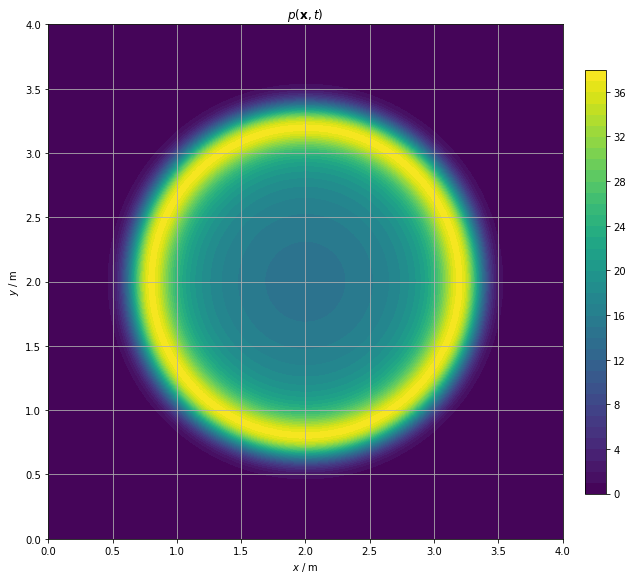

In [7]:
# define geometry and mesh
domain = mshr.Rectangle(dolfin.Point(0, 0), dolfin.Point(4,4))
mesh = mshr.generate_mesh(domain, 200)

# compute solution
u = FEM_wave_equation(mesh, T, 150, dolfin.Point(2,2), neumann_bc=True)

# plot sound field
plot_soundfield(u)
plt.grid()

The result of the numerical simulation is compared to the theoretical result given above for a line parallel to the y-axis for $y = 2$.

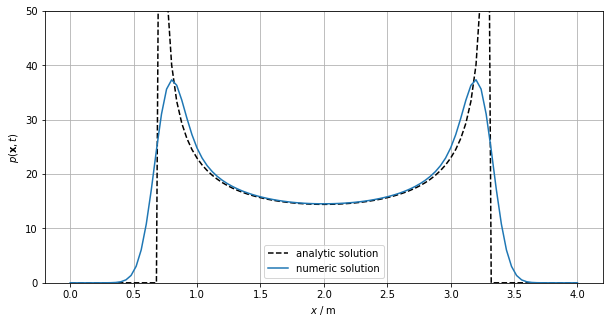

In [8]:
import numpy as np

# extract simulation results on line
x = np.linspace(0 + 1E-14, 4 - 1E-14, 101)
points = [(x_, 2) for x_ in x]
ux = [u(point) for point in points]

# compute analytic result on line
px = np.zeros(len(x))
a = (150*T)**2 - (np.sqrt((x-2)**2 + (2-2)**2)/343)**2
px[a>0] = 0.34 * 1/(2*np.pi * np.sqrt(a[a>0]))

# plot comparison
plt.figure(figsize=(10,5))
plt.plot(x, px, 'k--' , label='analytic solution')
plt.plot(x, ux, label='numeric solution')
plt.xlabel(r'$x$ / m')
plt.ylabel(r'$p(\mathbf{x}, t)$')
plt.legend()
plt.ylim([0, 50]);
plt.grid()

### Sound Field in Two Coupled Rectangular Rooms#

In order to illustrate the procedure for a more complex geometry, the sound field in two coupled rectangular rooms with sound-hard boundaries is computed. First, the geometry of the problem is defined and the mesh is plotted with a low number of elements for ease of illustration.

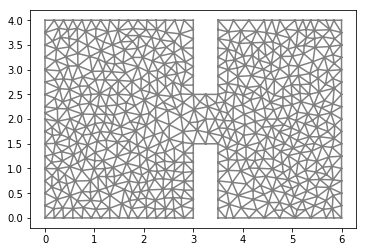

In [9]:
# define geometry and compute low resolution mesh for illustration
domain = mshr.Rectangle(dolfin.Point(0, 0), dolfin.Point(3,4)) + \
         mshr.Rectangle(dolfin.Point(3, 1.5), dolfin.Point(3.5, 2.5)) + \
         mshr.Rectangle(dolfin.Point(3.5, 0), dolfin.Point(6, 4))
mesh = mshr.generate_mesh(domain, 20)

dolfin.plot(mesh);

Now the problem is defined and solved with FEniCS with a high density mesh. The source position is chosen as $\mathbf{x}_s = (2,1)$ m and the total number of time-steps as $N=300$.

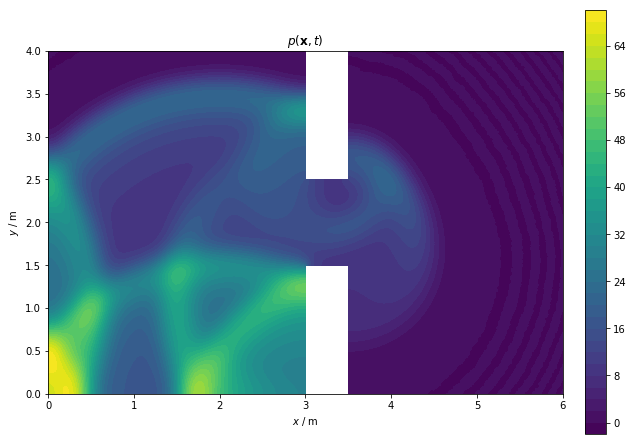

In [10]:
# high resolution mesh for FEM simulation
mesh = mshr.generate_mesh(domain, 150)

# compute solution
u = FEM_wave_equation(mesh, T, 300, dolfin.Point(2,1), neumann_bc=True)

# plot sound field
plot_soundfield(u)

**Copyright**

This notebook is provided as [Open Educational Resource](https://en.wikipedia.org/wiki/Open_educational_resources). Feel free to use the notebook for your own purposes. The text is licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/), the code of the IPython examples under the [MIT license](https://opensource.org/licenses/MIT).